![enter image description here](https://img.shields.io/badge/Author-Nestor_Batista_Díaz-yellow)

# <center>AREA MODELOS DE PYTHON A TENSORFLOW.JS</center>

## De  grados Fahrenheita a Celsius

In [54]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import  train_test_split

Generamos 1000 filas con los grados Fahrenheit y sus respectivos grados Celsius

In [55]:
# Crea un DataFrame vacío para almacenar los valores
df = pd.DataFrame(columns=['Celsius', 'Fahrenheit'])

# Genera 1000 valores aleatorios de Celsius
for i in range(1000):
    celsius = random.uniform(-100, 100)

    # Convierte Celsius a Fahrenheit
    fahrenheit = (celsius * 9/5) + 32

    # Agrega los valores al DataFrame
    df.loc[i] = [round(celsius,2), round(fahrenheit,2)]

df.to_csv("Grados/grados.csv")

Creamos el modelo según el video y lo entrenamos

In [56]:
df = pd.read_csv("Grados/grados.csv")

y = df["Celsius"]
X = df["Fahrenheit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

oculta1 = tf.keras.layers.Dense(units=3, input_shape=[1])
oculta2 = tf.keras.layers.Dense(units=3)
salida = tf.keras.layers.Dense(units=1)
modelo = tf.keras.Sequential([oculta1, oculta2, salida])


modelo.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss='mean_squared_error'
)

print("Comenzando entrenamiento...")
historial = modelo.fit(X_train, y_train, epochs=300, verbose=False, validation_split=0.05)
print("Modelo entrenado!")

Comenzando entrenamiento...
Modelo entrenado!


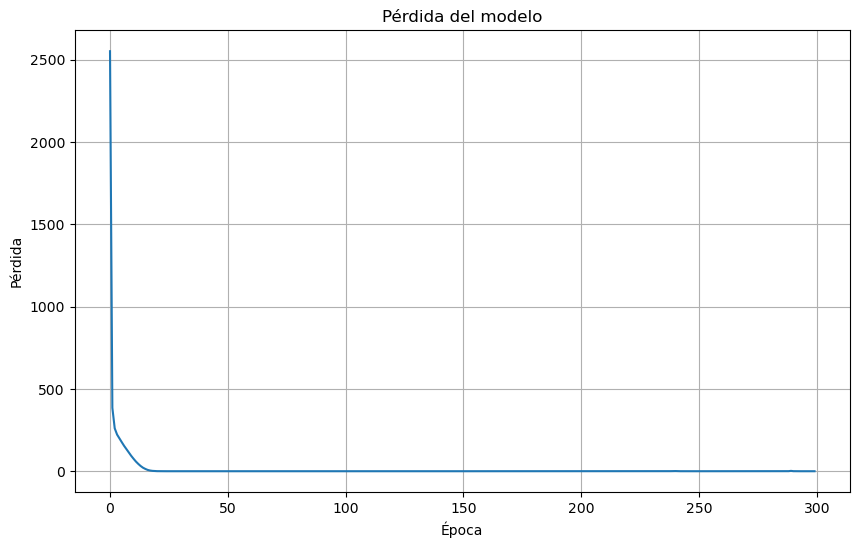

In [57]:
# Obtener la historia de entrenamiento del modelo
loss = historial.history['loss']

# Crear la gráfica de la pérdida
plt.figure(figsize=(10, 6))
plt.plot(loss)
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.grid(True)
plt.show()

Como podemos ver el modelo aprende muy rapido 

In [58]:
mse = modelo.evaluate(X_test, y_test, batch_size=32, verbose=0)

print("MSE: ", mse)

MSE:  1.3885900443710852e-05


El error del modelo es muy bajo

In [59]:
resultado = modelo.predict(np.array([100]), verbose=0)
print("Predicción: 100 grados Fahrenheit son {:.2f} Celsius!".format(resultado[0][0]))

Predicción: 100 grados Fahrenheit son 37.78 Celsius!


Guardamos el modelo para pasarselo a tensorflowjs y nos genere el json del modelo

In [60]:
#Exportar el modelo en formato h5
modelo.save('Grados/fahrenheit_a_celsius.h5')

c:\Users\NestorBD\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


El siguiente paso lo ejecute en Google Colab ya que en local no funcina el tensorflowjs por un problema de versiones.

[Google Colab](https://colab.research.google.com/drive/1VnXv8A3kS80swxJXS_S5YUUPWViX4Bxb#scrollTo=nIRjsmPBk51a)

Subimos el modelo guardado anteriormente

![image.png](Grados/img/Subir%20modelo.png)

Creamos la carpeta de salida e instalamos tensorflowjs

![image.png](Grados/img/crear%20carpeta%20y%20instalar%20tensorflowjs.png)

Con tensorflowjs generamos los archivos json y bin necesarios para mostrar los resultados en la web

![image.png](Grados/img/generar%20json.png)

Aqui podemos ver los archivos generados, ahora los descargamos en la carpeta donde tenemos guardado la pagina web

![image.png](Grados/img/archivos%20generados.png)

Abrimos el servidor en la carpeta donde tenemos guardado la pagina web

![image.png](Grados/img/abrir%20servidor.png)

Y por ultimo abrimos el siguiente [link](http://localhost:8000) en el navegador

![image.png](Grados/img/Fahreanheit%20a%20Celsius%20WEB.png)

## Clasificación de flores

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
import splitfolders
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Definimos la carpeta en donde se encuentran las imagenes con las que vamos a entrenar el modelo

In [2]:
original_path = "Flores/flowers"
print(os.listdir(original_path))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


Creamos un MAP con las especies de flores que tenemos para entrenar y definimos el tamaño de las imagenes

In [4]:
MAP_FLOWERS = {
    0: 'daisy', 1: 'dandelion', 2: 'rose', 
    3: 'sunflower', 4: 'tulip'
}

# Vamos a standarizar todas las imágenes a tamaño 128x128
IMG_SIZE = 128

Dividimos los archivos en tres conjuntos entrenamiento, validación y pruebas

In [4]:
splitfolders.ratio('Flores/flowers',seed=1337, output="Flores/Flowers-Splitted", ratio=(0.6, 0.2, 0.2))

Copying files: 2131 files [00:33, 60.96 files/s]

Creamos las funciones para cargar las imagenes

In [6]:
def load_train_set(dirname, map_pieces, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_pieces: variable de mapeo entre labels y piezas
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, piece in map_pieces.items():
        files = os.listdir(os.path.join(dirname, piece))
        images = [file for file in files if (file.endswith("jpg") or file.endswith("png") or file.endswith("jpeg") or file.endswith("JPG"))]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), piece))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, piece, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [7]:
def load_test_or_val_set(dirname, map_pieces, verbose=True, isTest=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    for label, piece in map_pieces.items():
        files = os.listdir(os.path.join(dirname, piece))
        images = [file for file in files if (file.endswith("jpg") or file.endswith("png") or file.endswith("jpeg") or file.endswith("JPG"))]
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, piece, image_name))
            X_test.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_test.append(label)
    if verbose:
        if isTest:
            print("Leídas {} imágenes de test".format(len(X_test)))
        else:
            print("Leídas {} imágenes de val".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

Cargamos los datos.

In [10]:
DATASET_TRAIN_PATH = "Flores/Flowers-Splitted/train"
DATASET_VAL_PATH = "Flores/Flowers-Splitted/val"
DATASET_TEST_PATH = "Flores/Flowers-Splitted/test"

X, y = load_train_set(DATASET_TRAIN_PATH, MAP_FLOWERS)
X_v, y_v = load_test_or_val_set(DATASET_TEST_PATH, MAP_FLOWERS, isTest=False)
X_t, y_t = load_test_or_val_set(DATASET_TEST_PATH, MAP_FLOWERS)

Leyendo 300 imágenes encontradas de daisy
Leyendo 387 imágenes encontradas de dandelion
Leyendo 298 imágenes encontradas de rose
Leyendo 297 imágenes encontradas de sunflower
Leyendo 364 imágenes encontradas de tulip
Leídas 552 imágenes de val
Leídas 552 imágenes de test


Aumentamos los datos de entrenamiento

In [11]:
#Aumento de datos
image_gen_entrenamiento = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [12]:
#Generacion de datos de entrenamiento FTW
data_gen_entrenamiento = image_gen_entrenamiento.flow_from_directory(batch_size=100,
                                                     directory="Flores/Flowers-Splitted/train",
                                                     shuffle=True,
                                                     target_size=(IMG_SIZE,IMG_SIZE),
                                                     class_mode='categorical')

Found 1646 images belonging to 5 classes.


Rescalamos los datos de validación para que sean iguales a los de entrenamiento.

In [13]:
#Generacion de datos de validacion
image_gen_val = ImageDataGenerator(rescale=1./255)

data_gen_validacion = image_gen_val.flow_from_directory(batch_size=100,
                                                 directory="Flores/Flowers-Splitted/val",
                                                 target_size=(IMG_SIZE, IMG_SIZE),
                                                 class_mode='categorical')

Found 548 images belonging to 5 classes.


Craemos el modelo muy sencillo, tal cual esta en el video,solo cambiando los datos de salida, sino puede dar fallos.

In [42]:
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

Compilación y entrenamiento

In [43]:
#Compilación
modelo.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Entrenar la red. Toma un buen rato! Ve por un café ;)
#Oye suscribete al canal!
print("Entrenando modelo...");
epocas=60
history = modelo.fit(
    data_gen_entrenamiento,
    steps_per_epoch=int(np.ceil(len(X) / float(100))),
    epochs=epocas,
    validation_data=data_gen_validacion,
    validation_steps=int(np.ceil(len(X_v) / float(100)))
)

print("Modelo entrenado!");

Entrenando modelo...
Epoch 1/60


c:\Users\NestorBD\anaconda3\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


17/17 [==============================] - 37s 2s/step - loss: 1.5333 - accuracy: 0.2807 - val_loss: 1.2777 - val_accuracy: 0.4507
Epoch 2/60
17/17 [==============================] - 33s 2s/step - loss: 1.2364 - accuracy: 0.4459 - val_loss: 1.2061 - val_accuracy: 0.4653
Epoch 3/60
17/17 [==============================] - 33s 2s/step - loss: 1.1604 - accuracy: 0.5200 - val_loss: 1.1896 - val_accuracy: 0.5182
Epoch 4/60
17/17 [==============================] - 33s 2s/step - loss: 1.0834 - accuracy: 0.5462 - val_loss: 1.0571 - val_accuracy: 0.5803
Epoch 5/60
17/17 [==============================] - 34s 2s/step - loss: 1.1077 - accuracy: 0.5504 - val_loss: 1.0573 - val_accuracy: 0.5584
Epoch 6/60
17/17 [==============================] - 33s 2s/step - loss: 0.9912 - accuracy: 0.5869 - val_loss: 0.9339 - val_accuracy: 0.6533
Epoch 7/60
17/17 [==============================] - 33s 2s/step - loss: 0.9681 - accuracy: 0.6094 - val_loss: 1.1317 - val_accuracy: 0.5675
Epoch 8/60
17/17 [=============

In [44]:
def plot_acc(history, title="Model Accuracy"):
  """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
def plot_loss(history, title="Model Loss"):
  """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

En la siguiente grafica podemos observar la variacion de aciertos de los datos de entrenamiento con respecto a los de validación, van mas o menos a la par.

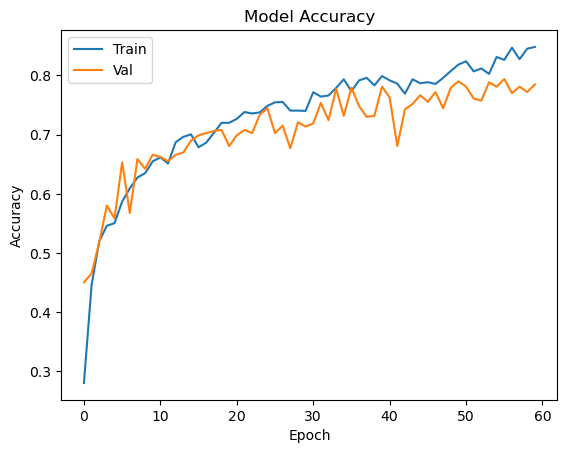

In [45]:
plot_acc(history)

En este otro grafico vemos la misma comparación pero con los datos de perdida, vemos que a partir de la empoca 50 se empiezan a separar mucho, se recomendaria parar ahi o incluso en la 40 donde ya se aprecia una separación considerable.

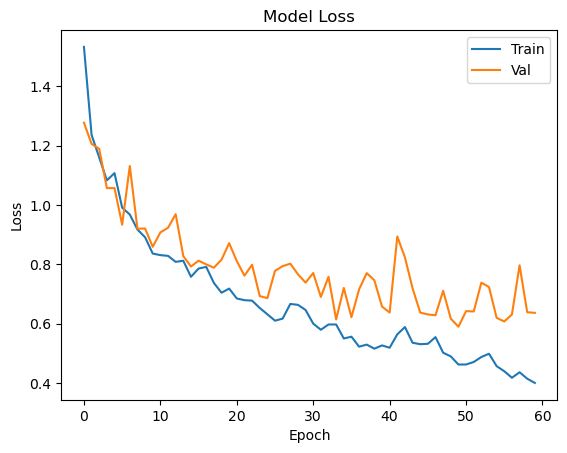

In [46]:
plot_loss(history)

Normalizamos los datos de test para comprobar nuestro modelo entrenado.

In [47]:
#Generacion de datos de test
image_gen_test = ImageDataGenerator(rescale=1./255)

data_gen_test = image_gen_test.flow_from_directory(batch_size=100,
                                                 directory="Flores/Flowers-Splitted/test",
                                                 target_size=(IMG_SIZE, IMG_SIZE),
                                                 class_mode='categorical')
# Obtener un lote de datos
X_test, y_test = data_gen_test.next()

Found 552 images belonging to 5 classes.


Evaluamos el modelo y comprobamos que sale correctamente, el resultado es bastante aceptable, lo que se esperaba.

In [48]:
modelo.evaluate(X_test, y_test, batch_size=32, verbose=1)

4/4 [==============================] - 0s 35ms/step - loss: 0.7134 - accuracy: 0.7600


[0.713397741317749, 0.7599999904632568]

Generamos la matriz de confusión

In [49]:
LABELS = ['daisy','dandelion', 'rose', 
'sunflower', 'tulip']
def mostrar_resultados(model, X_test, y_test, pred_y):
    pred_y = np.argmax(pred_y, axis=1)
    y_test = np.argmax(y_test, axis=1)
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

    print (classification_report(y_test, pred_y))

4/4 [==============================] - 0s 33ms/step


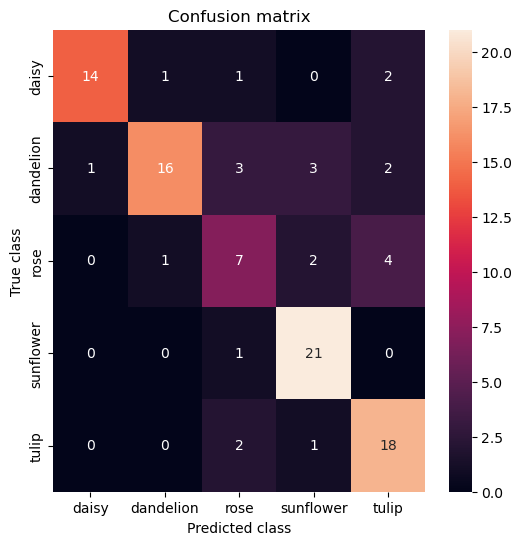

              precision    recall  f1-score   support

           0       0.93      0.78      0.85        18
           1       0.89      0.64      0.74        25
           2       0.50      0.50      0.50        14
           3       0.78      0.95      0.86        22
           4       0.69      0.86      0.77        21

    accuracy                           0.76       100
   macro avg       0.76      0.75      0.74       100
weighted avg       0.78      0.76      0.76       100



In [50]:
y_pred = modelo.predict(X_test)
mostrar_resultados(history, X_test, y_test, y_pred)

En la matriz podemos comprobar que acierta bastante en todas las categorias a ecepción de la rosa, lo cual es aceptable para esta tarea de clase

Exportamos el modelo

In [53]:
#Exportar el modelo en formato h5
modelo.save('Flores/flowers.h5')

Ahora, seguimos los mismos pasos que con el modelo anterior, subimos el modelo a el codigo de google colab para generar los archivos necesarios.

![image.png](Flores/img/Generar%20Json.png)

Descargamos los archivos de la carpeta output y los añadimos a la carpeta en donde se encuentra el html donde mostraremos el funcionamiento del modelo con la camara del movil conectado al ordenador.

Abrimos el servidor en la carpeta donde tenemos guardado la pagina web

![image.png](Flores/img/Abrir%20servidor.png)

Y por ultimo abrimos el [link](http://localhost:8001) en donde hemos alojado la web

![image.png](Flores/img/Visualización%20en%20la%20web.png)

![image.png](Flores/img/sunflower.png)